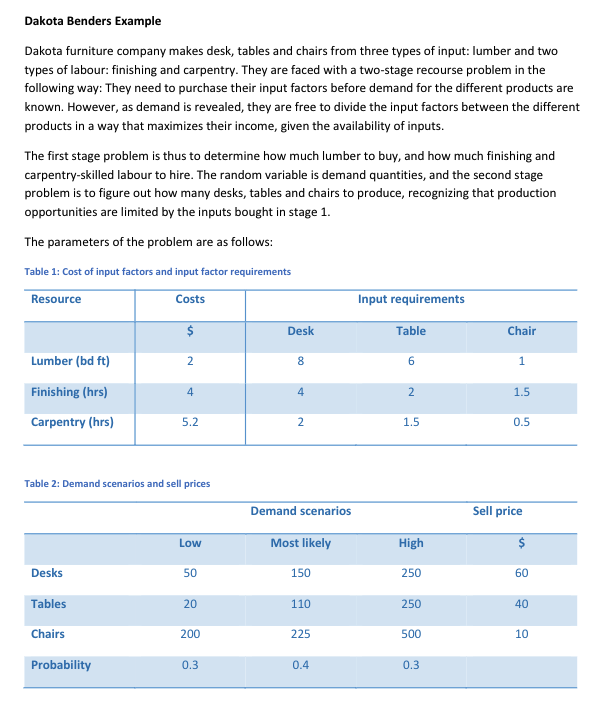

### Sets
- R: Set of resources
- P: Set of products
- S: Set of senarios

### Data
- $c_r$: cost/unit for resource r
- $u_{rp}$: usage of resource r per unit product p
- $prob_s$: probability of scenario s
- $d_{ps}$: demand for product p in scenario s
- $sell_p$: selling price of product p

### Vars
- $y_r$: amount of resource r to buy
- $x_{ps}$ amount of product p to sell in senario s

### Objective Function 

$$
\max \sum_{p \in P s \in S} prob_s x_{ps} - \sum_{r \in R} c_r y_r
$$

### Constraints
- Use less resources than you have bought for each scenario

$$
\sum_{p \in P} u_{rp} x_{ps} \leq y_r   \forall r \in R, s \in S
$$

- Cannot sell more than demand for each scenario

$$
x_{ps} \leq d_{ps} \forall p \in P, s \in S
$$

$$
x_{ps} \geq 0 \forall p \in P, s \in S
$$


In [5]:
import gurobipy as gp

EPS = 0.0001

Resources = ["Lumber", "Finishing", "Carpentry"]
Products = ["Desk", "Table", "Chair"]

R = range(len(Resources))
P = range(len(Products))

Cost = [2,4,5.2]
Input = [
        [8,6,1],
        [4,2,1.5],
        [2,1.5,0.5]]

Prob = [0.3,0.4,0.3]
S = range(len(Prob))

Demand = [
    [50,150,250],
    [20,110,250], 
    [200,225,500]]

Sell = [60,40,10]

m = gp.Model('Dakota')

Y = {r: m.addVar() for r in R}
X = {(p, s): m.addVar() for p in P for s in S}

ProductionLimit = {
    (r, s):
    m.addConstr(gp.quicksum(Input[r][p] * X[p, s] for p in P) <= Y[r])
    for r in R for s in S
}

DemandLimit = {
    (p, s):
    m.addConstr(X[p,s] <= Demand[p][s])
    for p in P for s in S
}

m.setObjective(
    gp.quicksum(Prob[s] * Sell[p] * X[p, s] for p in P for s in S)
    - gp.quicksum(Cost[r] * Y[r] for r in R),
    gp.GRB.MAXIMIZE
)

m.optimize()

print(f"Purchase: {[Y[r].x for r in R]}")
for s in S:
    print(s)
    print([X[p, s].x for p in P])
    print([ProductionLimit[r, s].Slack for r in R])

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 18 rows, 12 columns and 45 nonzeros
Model fingerprint: 0x5649da36
Coefficient statistics:
  Matrix range     [5e-01, 8e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+02]
Presolve removed 12 rows and 0 columns
Presolve time: 0.00s
Presolved: 6 rows, 12 columns, 42 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.0820000e+03   5.193750e+02   0.000000e+00      0s
       8    1.7300000e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.730000000e+03
Purchase: [1300.0, 540.0, 325.0]
0
[50.0, 20.0, 200.0]
[580.0, 0.0, 95.0]
1
[80.0, 110.0, 0.0]
[0.0, 0.0, 0.0]
2
[80.0, 110.0, 0.0]
[0.0, 0.0, 0.0]


We can split the problem up into per senario using benders decomposition

$$
\max \sum_{s \in S} prob_s \Theta_s (y) - \sum_{r \in R} c_r y_r
$$

Such that

$$
y_r \geq 0 + cuts
$$

---

$$
\Theta_s(y^*) \max \sum_{p \in P} sell_p x_{ps}
$$

Such that

$$
\sum_{p \in P} u_{rp} \leq y^*_r \forall r \in R
$$

$$
x_{ps} \leq d_{ps} \forall p \in P
$$

$$
x_ps \geq 0
$$

Work out how much the objective value chages as we change Y? sensitivity analysis! Dual constraints!

Objective at $y^*$

$$
\sum_{r \in R} \pi_{rs}^k y_r^* + \sum_{p \in P} \lambda_{ps}^k d_{ps}
$$

$$
\theta_s \leq \sum_{r \in R} \pi_{rs}^k y_r^* + \sum_{p \in P} \lambda_{ps}^k d_{ps}
$$

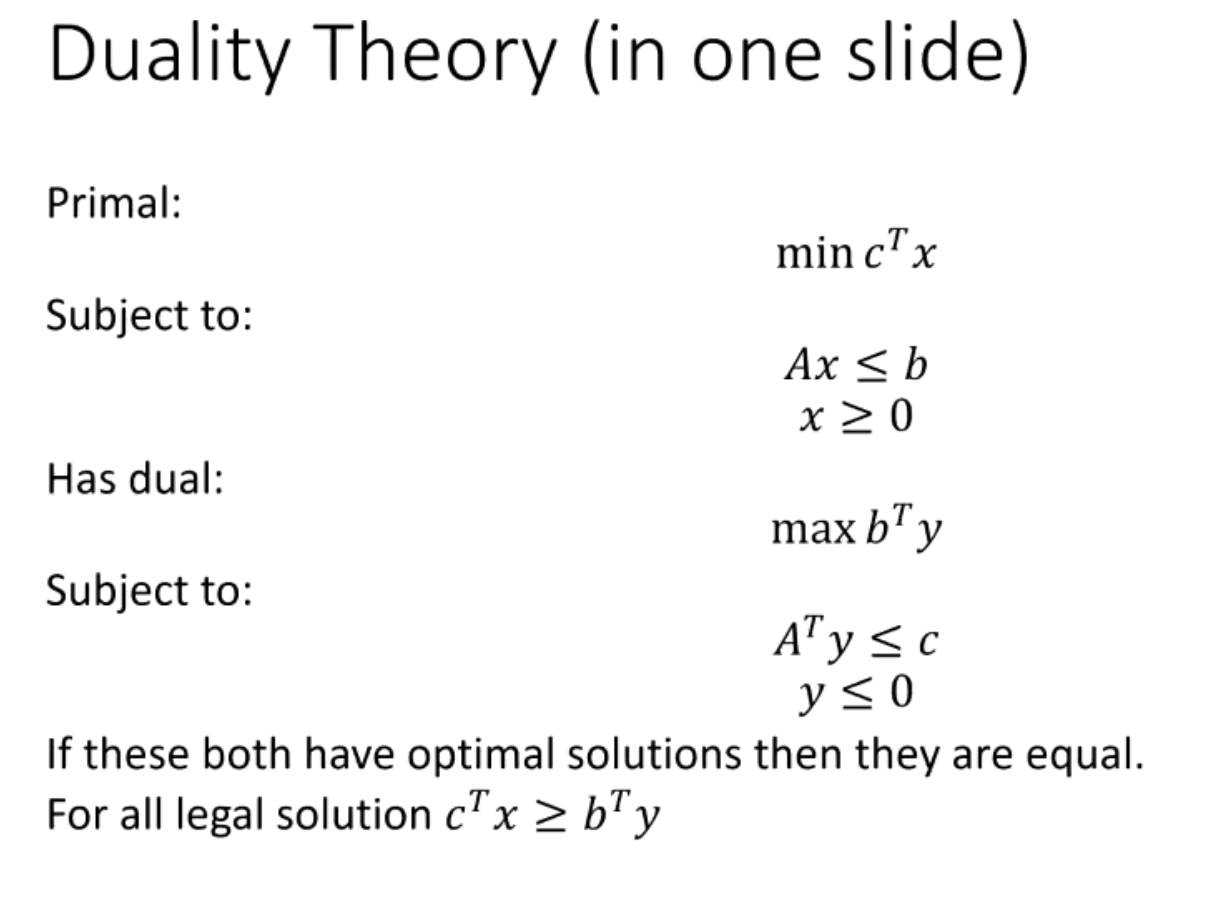


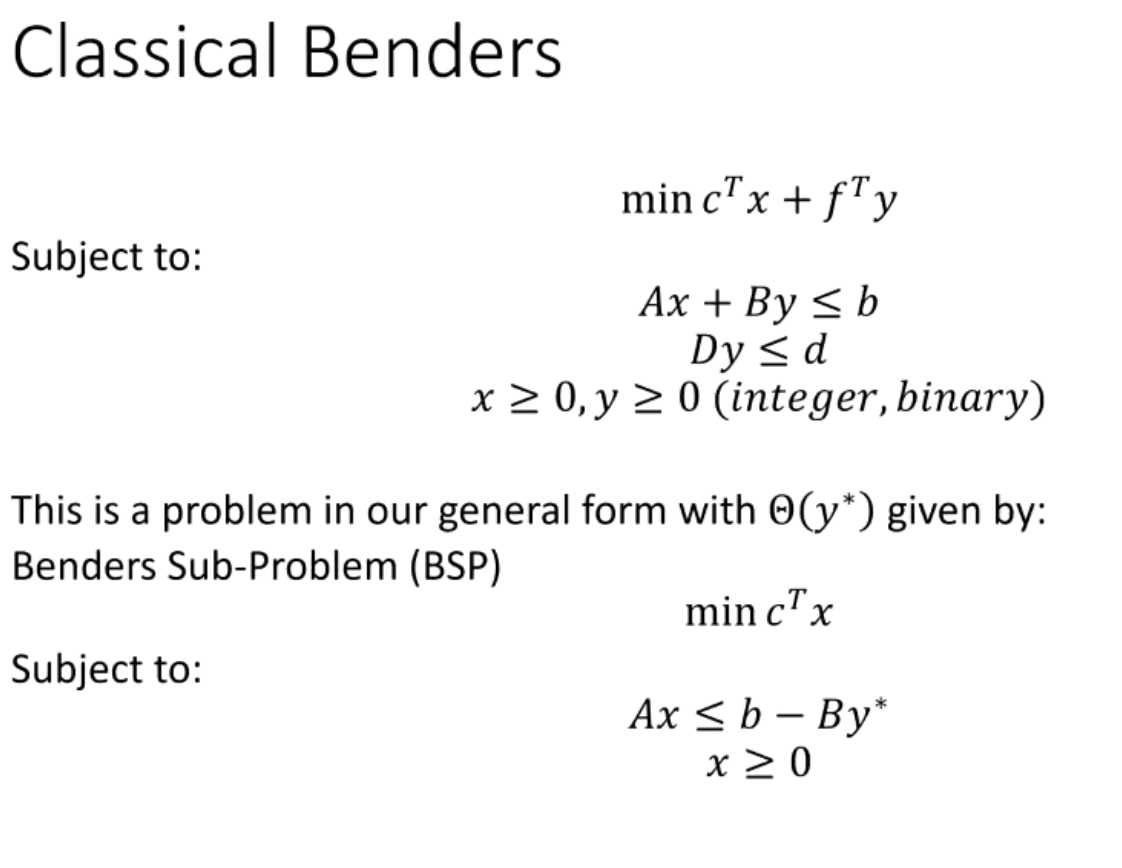

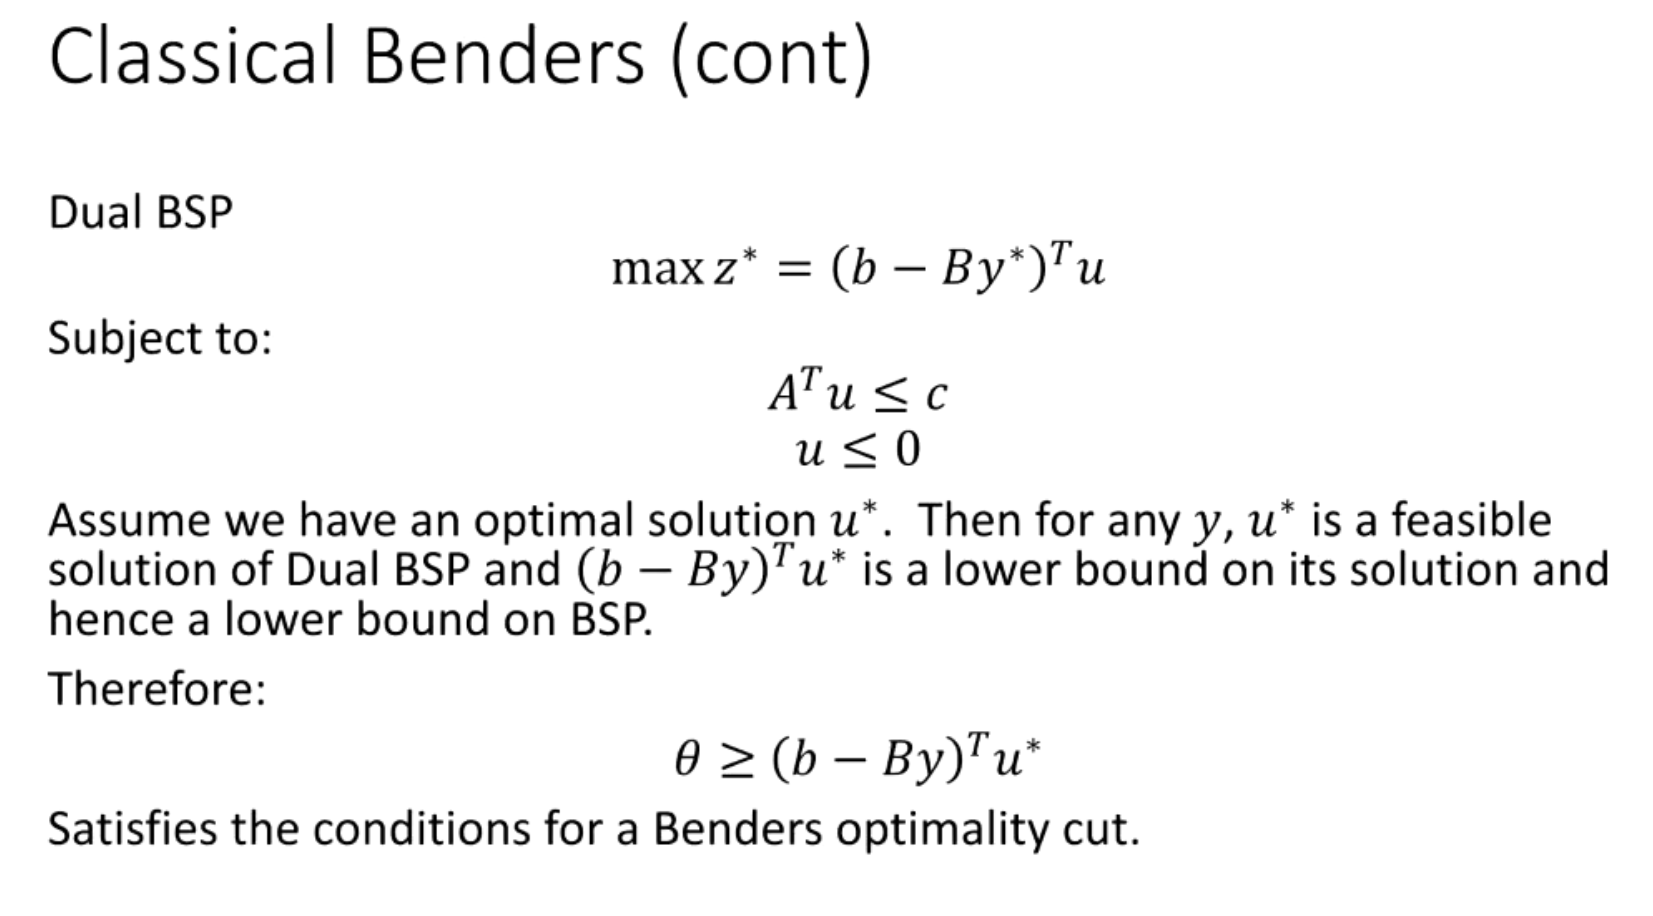

In [12]:
import gurobipy as gp

EPS = 0.0001

Resources = ["Lumber", "Finishing", "Carpentry"]
Products = ["Desk", "Table", "Chair"]

R = range(len(Resources))
P = range(len(Products))

Cost = [2,4,5.2]
Input = [
        [8,6,1],
        [4,2,1.5],
        [2,1.5,0.5]]

Prob = [0.3,0.4,0.3]
S = range(len(Prob))

Demand = [
    [50,150,250],
    [20,110,250], 
    [200,225,500]]

Sell = [60,40,10]

BMP = gp.Model('Dakota')

Y = {r: BMP.addVar() for r in R}
Theta = {s: BMP.addVar(ub = sum(Demand[p][s] * Sell[p] for p in P)) for s in S} # upper bound is if we match demand
# We need upper bound or we get unbounded master problem and we cannot add cuts

# OLD Objective
# m.setObjective(
#     gp.quicksum(Prob[s] * Sell[p] * X[p, s] for p in P for s in S)
#     - gp.quicksum(Cost[r] * Y[r] for r in R),
#     gp.GRB.MAXIMIZE
# )

# Theta represents the amount of money made (from selling items) in senario s
BMP.setObjective(
    gp.quicksum(Prob[s] * Theta[s] for s in S)
    - gp.quicksum(Cost[r] * Y[r] for r in R),
    gp.GRB.MAXIMIZE  
)

# SUB PROBLEMS
# Each sub problem "s" solves for the assosiated theta_s
BSP = {s: gp.Model() for s in S}

X = {(p, s): BSP[s].addVar() for p in P for s in S}

ProductionLimit = {
    (r, s):
    BSP[s].addConstr(gp.quicksum(Input[r][p] * X[p, s] for p in P) <= 0)
    for r in R for s in S
}

DemandLimit = {
    (p, s):
    BSP[s].addConstr(X[p,s] <= Demand[p][s])
    for p in P for s in S
}

for s in S:
    BSP[s].Params.OutputFlag = 0
    BSP[s].setObjective(
        gp.quicksum(Sell[p] * X[p, s] for p in P),
        gp.GRB.MAXIMIZE
    )

for k in range(10):
    # Solve master problem
    BMP.optimize()
    print('***********************************************')
    print(f'Y: {[Y[r].x for r in R]}')
    CutsAdded = 0
    for s in S:
        # Modify sub problem s using y*
        for r in R:
            ProductionLimit[r, s].RHS = Y[r].x  # y^*_r
        # Solve sub problem s
        BSP[s].optimize()
        print(f"    {Theta[s].x} {BSP[s].ObjVal}")
        # Check if objective of sub problem is smaller that theta
        if BSP[s].ObjVal < Theta[s].x - EPS:
            # Add an optimality cut
            BMP.addConstr(
                Theta[s] 
                <= 
                gp.quicksum(ProductionLimit[r, s].pi * Y[r] for r in R) 
                + sum(Demand[p][s] * DemandLimit[p, s].pi for p in P)
            )
            CutsAdded += 1
    if CutsAdded == 0:
        break
    print(f"CUTS: {CutsAdded}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 6 columns and 0 nonzeros
Model fingerprint: 0x3f4e94c4
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e-01, 5e+00]
  Bounds range     [6e+03, 3e+04]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7000000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.700000000e+04
***********************************************
Y: [0.0, 0.0, 0.0]
    5800.0 -0.0
    15650.0 -0.0
    30000.0 -0.0
CUTS: 3
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count